Import

In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [166]:
# Charger le dataset
df_base = pd.read_csv('data.csv', sep=';')
pd.set_option('display.max_columns', None) 
df = df_base
df.columns = df.columns.str.lower()

In [167]:
df_base

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


Dataviz pré traitement

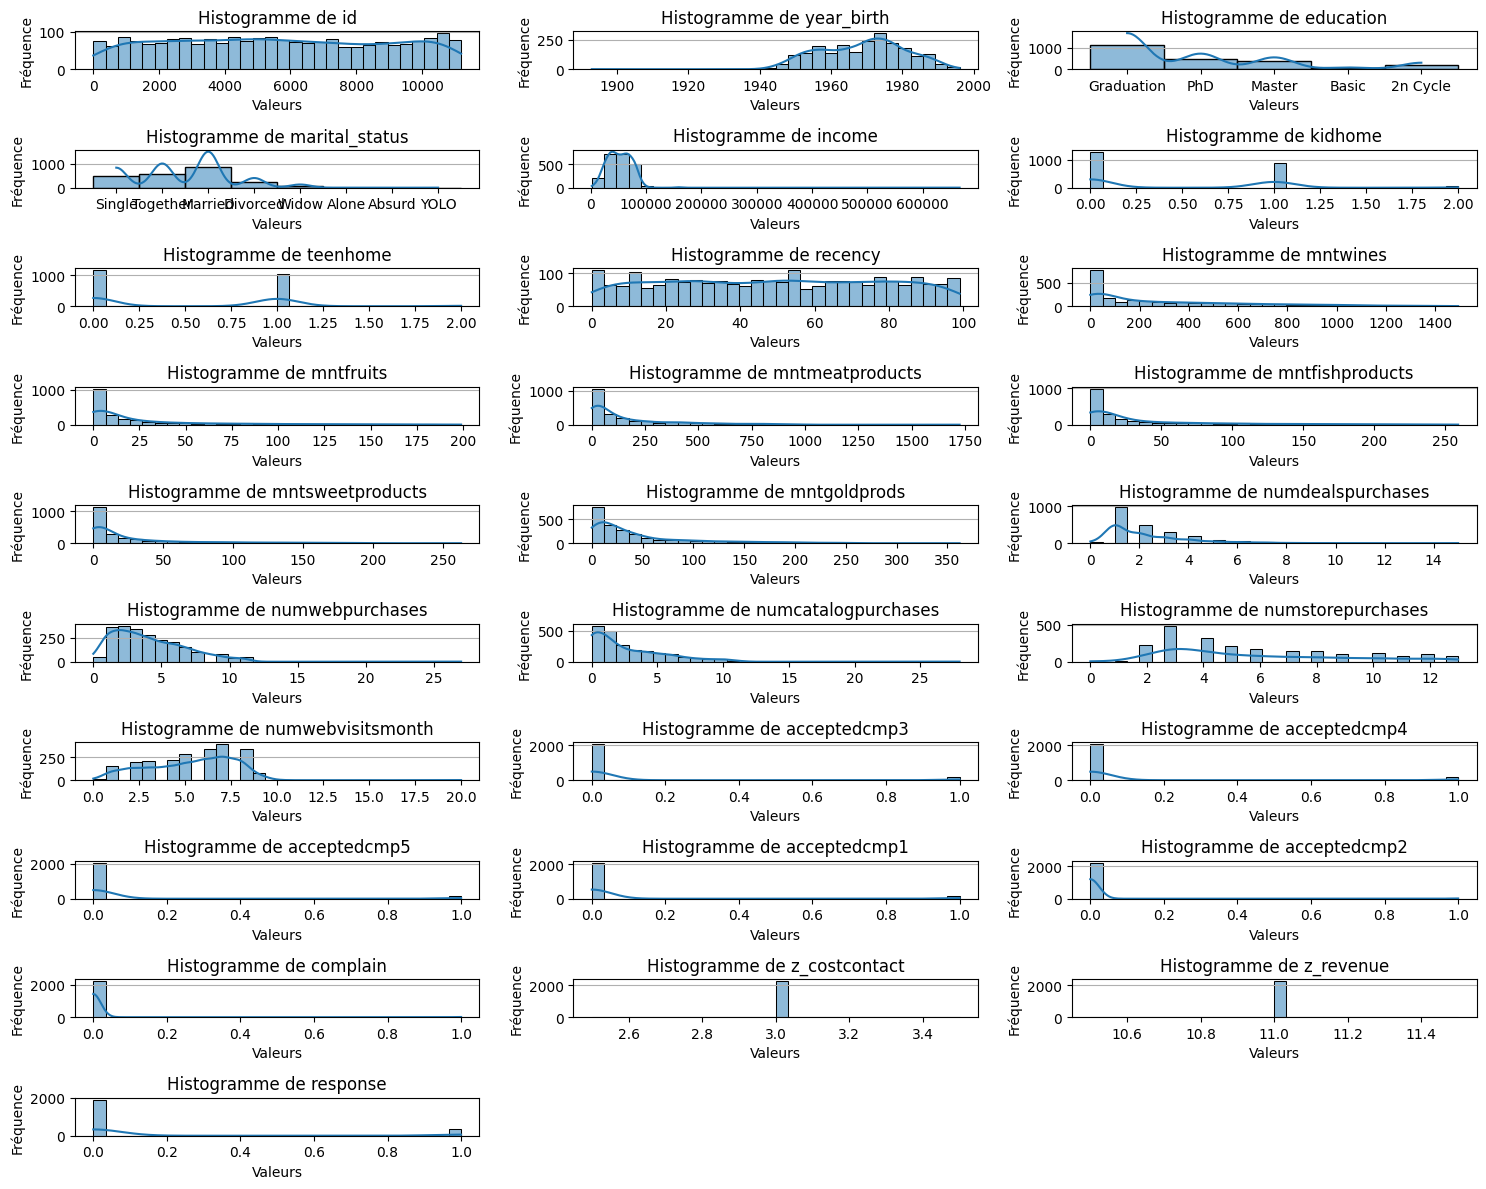

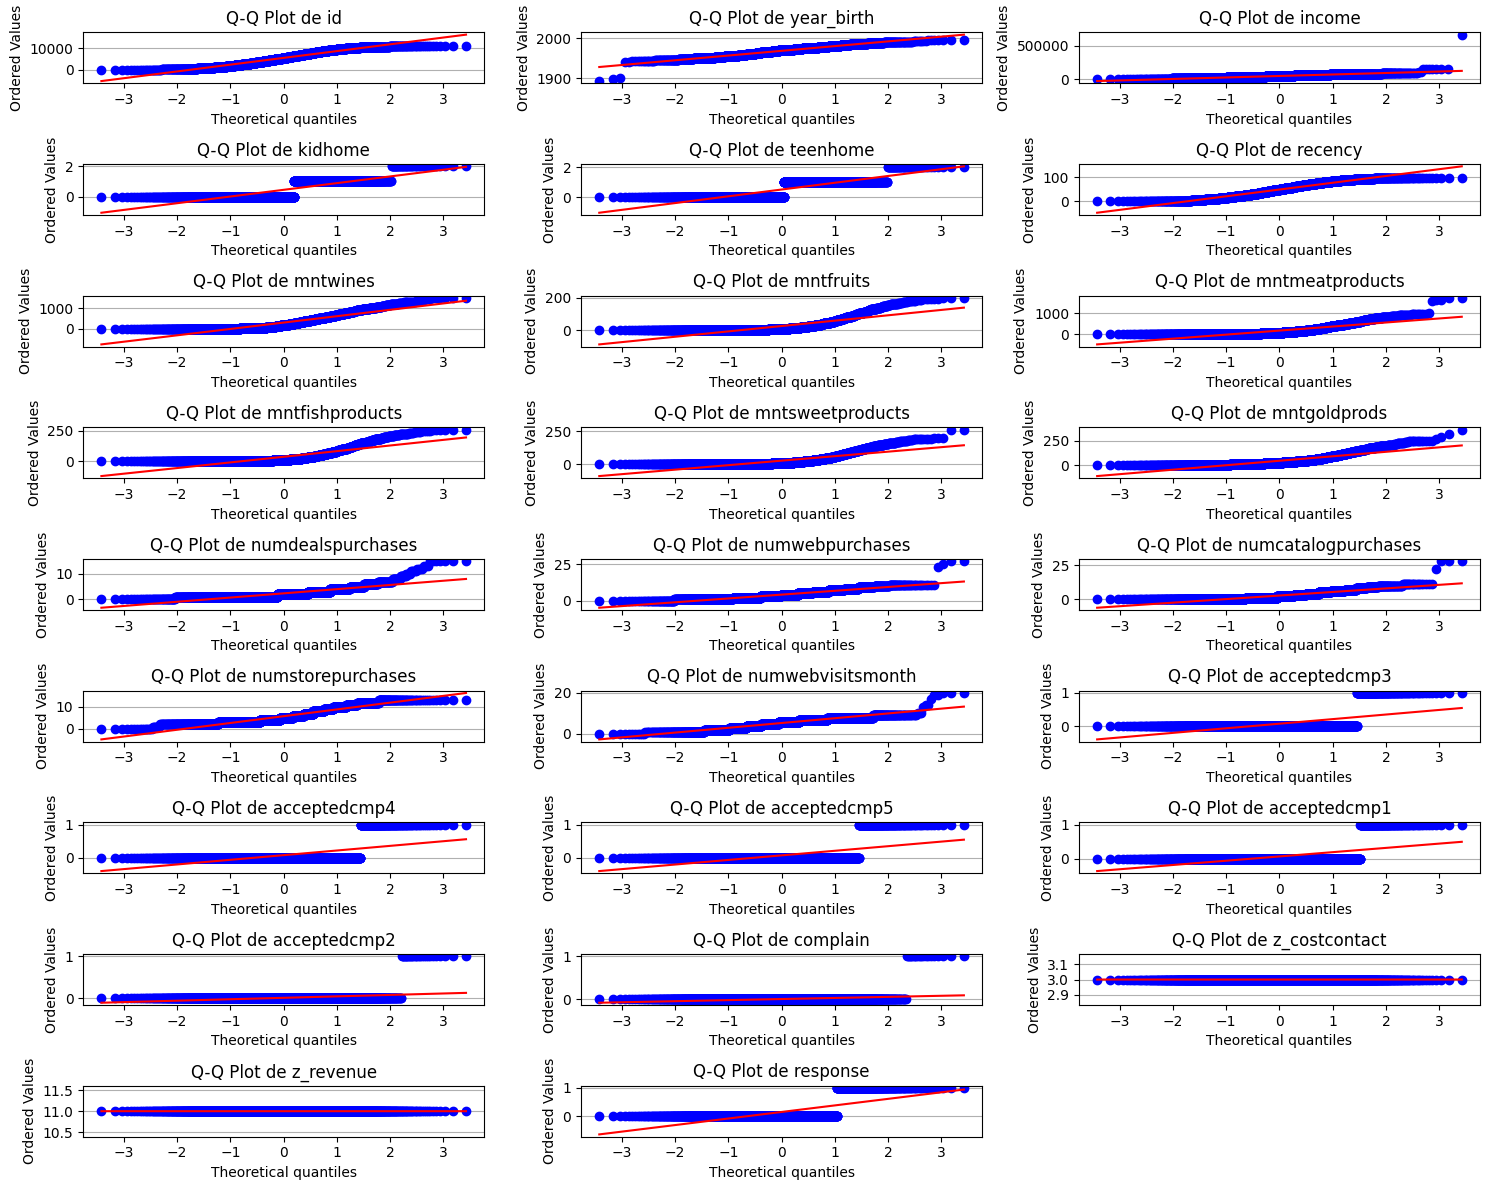

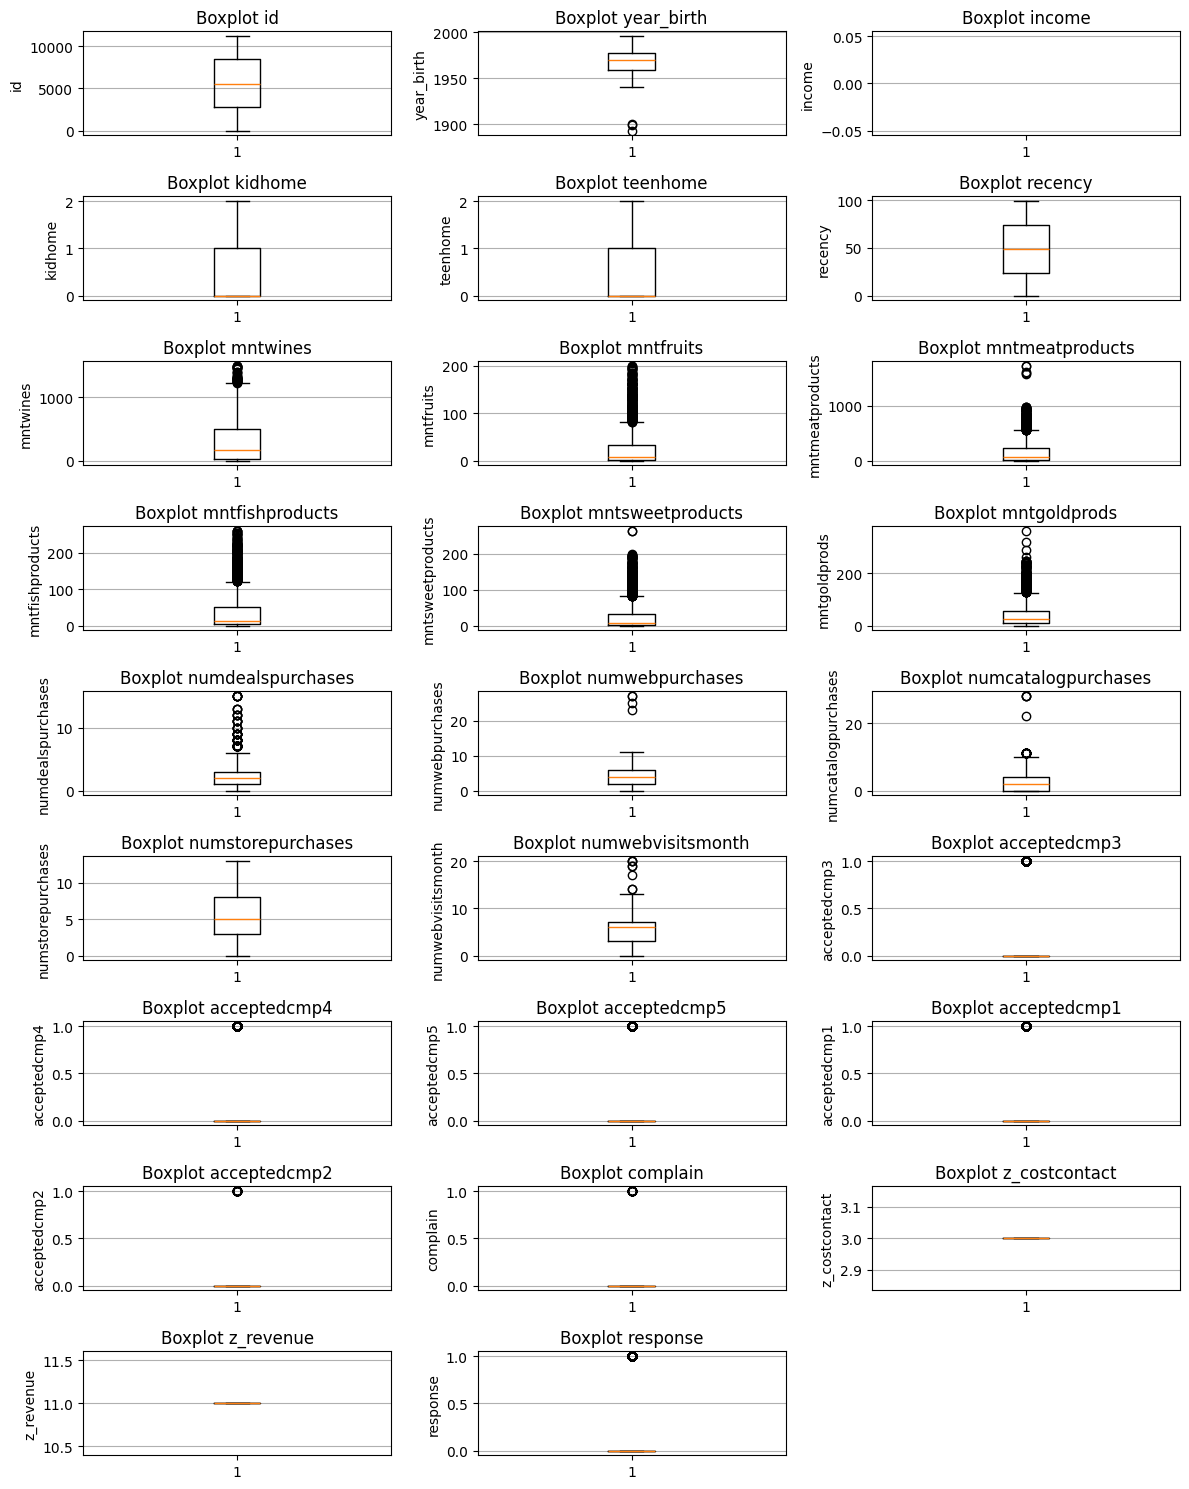

In [168]:
# Distribution des valeurs
cols = df_base.drop(columns='dt_customer').columns

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des histogrammes
for i, col in enumerate(cols):
    sns.histplot(df_base[col], bins=30, kde=True, ax=axes[i])  # Utiliser l'axe spécifique
    axes[i].set_title(f'Histogramme de {str(col)}')
    axes[i].set_xlabel('Valeurs')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()
# Supposons que df_base est déjà défini et que tu as les colonnes que tu veux analyser
cols = lambda: [
    col for col in df_base.columns if pd.api.types.is_numeric_dtype(df_base[col]) and (df_base[col] != 0).any() #verif si la colonne a des valeurs numérique + si pas de valeur == 0
]
res_cols = cols()

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(res_cols) // n_cols + (len(res_cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des Q-Q plots
for i, col in enumerate(res_cols):
    data = df_base[col].dropna()  # Supprimer les NaN
    if len(data) > 1:  # Vérifier que la longueur est suffisante
        stats.probplot(data, dist="norm", plot=axes[i])  # Utiliser l'axe spécifique
        axes[i].set_title(f'Q-Q Plot de {str(col)}')
    else:
        axes[i].set_title(f'Pas assez de données pour {str(col)}')  # Titre pour les colonnes insuffisantes
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(res_cols) < len(axes):
    for j in range(len(res_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()
### Générer boxplot pour valeurs aberrantes

cols = lambda: [
    col for col in df_base.columns if pd.api.types.is_numeric_dtype(df_base[col]) and (df_base[col] != 0).any() #verif si la colonne a des valeurs numérique + si pas de valeur == 0
]
res_cols = cols()

fig, axes = plt.subplots(nrows=len(res_cols)//3 + 1, ncols=3, figsize=(12, 15))  # 3 colonnes, lignes dynamiques

axes = axes.flatten()

for i, col in enumerate(res_cols):
    axes[i].boxplot(df_base[col])
    axes[i].set_title(f'Boxplot {str(col)}')
    axes[i].set_ylabel(str(col))
    axes[i].grid(axis='y')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


EDA

Description générale du dataset:
Nombre total d'observations : 2240
Nombre total de variables : 29
Types de données : 
id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response     

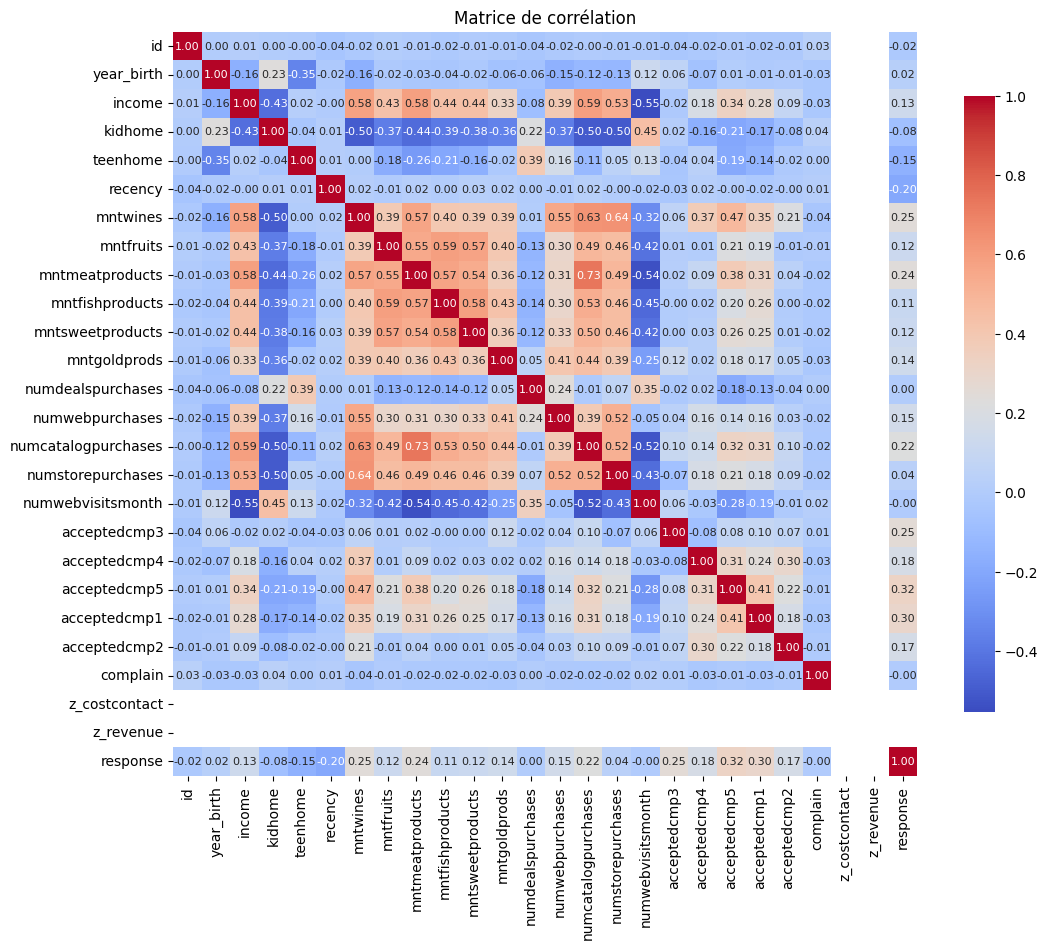

In [169]:
# Description générale du dataset
print("Description générale du dataset:")
print(f"Nombre total d'observations : {df.shape[0]}")
print(f"Nombre total de variables : {df.shape[1]}")
print(f"Types de données : \n{df.dtypes}")

# Liste des variables
print("\nListe des variables:")
print(df.columns.tolist())

# Statistiques descriptives pour les variables numériques
print("\nStatistiques descriptives pour les variables numériques:")
print(df.describe())

# Statistiques descriptives pour les variables catégorielles
print("\nStatistiques descriptives pour les variables catégorielles:")
print(df.describe(include=['object', 'category']))

# Valeurs manquantes
print("\nValeurs manquantes dans le dataset:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Valeurs aberrantes - par exemple pour les variables numériques
print("\nValeurs aberrantes (5 premières lignes) :")
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"\nValeurs aberrantes pour {column}:")
    print(df[column][df[column] > df[column].mean() + 2.8 * df[column].std()])  # Z-score > 3

# matrice de corrélation

plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(columns=['marital_status', 'education', 'dt_customer']).dropna().corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={'size' : 8})
plt.title('Matrice de corrélation')
plt.show()


In [170]:
# Suppression des variables sans variance
df = df.drop(columns=['z_revenue', 'z_costcontact'])

Remplacer les valeurs empoisonées + simplification valeurs

In [171]:
df['marital_status'] = df['marital_status'].apply(lambda x: "Married" if (x == "YOLO" or x == "Absurd" or x == "Together") else x)
df['marital_status'] = df['marital_status'].apply(lambda x: "Single" if (x == "Divorced" or x == "Widow" or x == "Alone") else x)

In [172]:
def tri_education(education):
    if education == 'Basic' or education == '2n Cycle':
        return "Undergrad"
    elif education == 'Graduation':
        return "Grad"
    else:
        return "Postgrad"

df['education'] = df['education'].apply(tri_education)

Nouvelles variables

In [173]:
df.rename(columns={'marital_status': 'live_alone'}, inplace=True)

In [174]:
df.rename(columns={'year_birth': 'age'}, inplace=True)
df['age'] = 2024 - df['age']

In [175]:
df['n_children'] = df['kidhome'] + df['teenhome']
for cel in df['live_alone']:
    if cel == 1 :
        df['n_familly'] = df['n_children'] + 1
    else :
        df['n_familly'] = df['n_children'] + 2

df = df.drop(columns= ['kidhome', 'teenhome'])

In [176]:
df['n_accepted_offer'] = df['acceptedcmp1'] + df['acceptedcmp2'] + df['acceptedcmp3'] + df['acceptedcmp4'] + df['acceptedcmp5'] 
df = df.drop(columns=['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5'])

In [177]:
def tri_n_accepted_offer(n_accepted_offer):
    if n_accepted_offer == 4:
        return 3
    else :
        return n_accepted_offer

df['n_accepted_offer'] = df['n_accepted_offer'].apply(tri_n_accepted_offer)
df['n_accepted_offer'].value_counts()

n_accepted_offer
0    1777
1     325
2      83
3      55
Name: count, dtype: int64

In [178]:
df.rename(columns={'dt_customer': 'day_since_1st_order'}, inplace=True)
df['day_since_1st_order'] = (pd.to_datetime('today') - pd.to_datetime(df['day_since_1st_order'])).dt.days

In [179]:
df['spent'] = df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

In [180]:
df['is_parent'] = [1 if cel > 0 else 0 for cel in df['n_children']]

In [181]:
col_bin = df[['live_alone', 'complain', 'response', 'is_parent']]

Encoder variable catégorielle

In [182]:
df['live_alone'].value_counts()

live_alone
Married    1448
Single      792
Name: count, dtype: int64

In [183]:
label_encoder = LabelEncoder()
label_encoder.fit(df['live_alone'])
df["live_alone"] = label_encoder.transform(df['live_alone'])

In [184]:
ordinal_encoder = OrdinalEncoder(categories=[['Undergrad', 'Grad', 'Postgrad']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

In [185]:
df.head()

,id,age,education,live_alone,income,day_since_1st_order,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,complain,response,n_children,n_familly,n_accepted_offer,spent,is_parent
0,5524,67,1.0,1,58138.0,4426,58,635,88,546,172,88,88,3,8,10,4,7,0,1,0,2,0,894,0
1,2174,70,1.0,1,46344.0,3876,38,11,1,6,2,1,6,2,1,1,2,5,0,0,2,4,0,15,1
2,4141,59,1.0,0,71613.0,4075,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,2,0,301,0
3,6182,40,1.0,0,26646.0,3902,26,11,4,20,10,3,5,2,2,0,4,6,0,0,1,3,0,38,1
4,5324,43,2.0,0,58293.0,3924,94,173,43,118,46,27,15,5,5,3,6,5,0,0,1,3,0,206,1


Remplacer les valeurs aberrantes

In [186]:
aberrant_col = df[['age', 'income', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numwebvisitsmonth', 'numcatalogpurchases', 'spent', 'n_familly', 'n_children', ]].columns
 

In [187]:
for column in aberrant_col:

    mask = df[column] > df[column].mean() + 3.5 * df[column].std()
    df.loc[mask, column] = np.nan

df.isnull().sum()

id                      0
age                     3
education               0
live_alone              0
income                 32
day_since_1st_order     0
recency                 0
mntwines                4
mntfruits              32
mntmeatproducts        10
mntfishproducts        21
mntsweetproducts       32
mntgoldprods           25
numdealspurchases      24
numwebpurchases         4
numcatalogpurchases     4
numstorepurchases       0
numwebvisitsmonth       8
complain                0
response                0
n_children              0
n_familly               0
n_accepted_offer        0
spent                   7
is_parent               0
dtype: int64

SimpleImputer

In [188]:
# imputer = SimpleImputer(strategy='mean')
# df[aberrant_col] = imputer.fit_transform(df[aberrant_col])

In [189]:
# for column in aberrant_col:

#     mask = df[column] > df[column].mean() +  3.5 * df[column].std()
#     df.loc[mask, column] = np.nan

# df.isnull().sum()

Remplacer NaN aberrant KNN Imputer A VOIR PLUS TARD

In [190]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled = scaler.fit_transform(df_scaled)

In [191]:
imputer = KNNImputer(n_neighbors=3, weights='distance')
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_imputed_temp = scaler.inverse_transform(df_imputed_scaled)
df_imputed = pd.DataFrame(df_imputed_temp, columns=df.columns, index=df.index)

In [192]:
new_order = [
    'id', 'education', 'age', 'income', 'n_children', 'n_familly', 'is_parent', 
    'live_alone', 'day_since_1st_order', 'recency', 'mntwines', 'mntfruits', 
    'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 
    'spent', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 
    'numstorepurchases', 'numwebvisitsmonth', 'n_accepted_offer', 'complain', 'response'
]

# Réordonner les colonnes du DataFrame
df_imputed = df_imputed[new_order]

# outliers_count = 0

# for column in aberrant_col:
#     # Créer un masque pour identifier les valeurs aberrantes
#     mask = df[column] > df[column].mean() + 2.8 * df[column].std()

#     # Compter le nombre de valeurs aberrantes pour cette colonne
#     outliers_count += mask.sum()

# # Afficher le nombre total de valeurs aberrantes
# print("Nombre total de valeurs aberrantes :", outliers_count)

In [193]:
# for column in aberrant_col:
#     # Créer un masque pour identifier les valeurs aberrantes dans les deux directions
#     mask = (df_imputed[column] > df_imputed[column].mean() + 2.8 * df_imputed[column].std()) | (df_imputed[column] < df_imputed[column].mean() - 3.5 * df_imputed[column].std())

#     # Compter le nombre de valeurs aberrantes pour cette colonne
#     outliers_count = mask.sum()

#     # Afficher le résultat pour chaque colonne
#     print(f"{column} : {outliers_count}")


In [194]:
df_imputed.isnull().sum()

id                     0
education              0
age                    0
income                 0
n_children             0
n_familly              0
is_parent              0
live_alone             0
day_since_1st_order    0
recency                0
mntwines               0
mntfruits              0
mntmeatproducts        0
mntfishproducts        0
mntsweetproducts       0
mntgoldprods           0
spent                  0
numdealspurchases      0
numwebpurchases        0
numcatalogpurchases    0
numstorepurchases      0
numwebvisitsmonth      0
n_accepted_offer       0
complain               0
response               0
dtype: int64

Dataviz post traitement

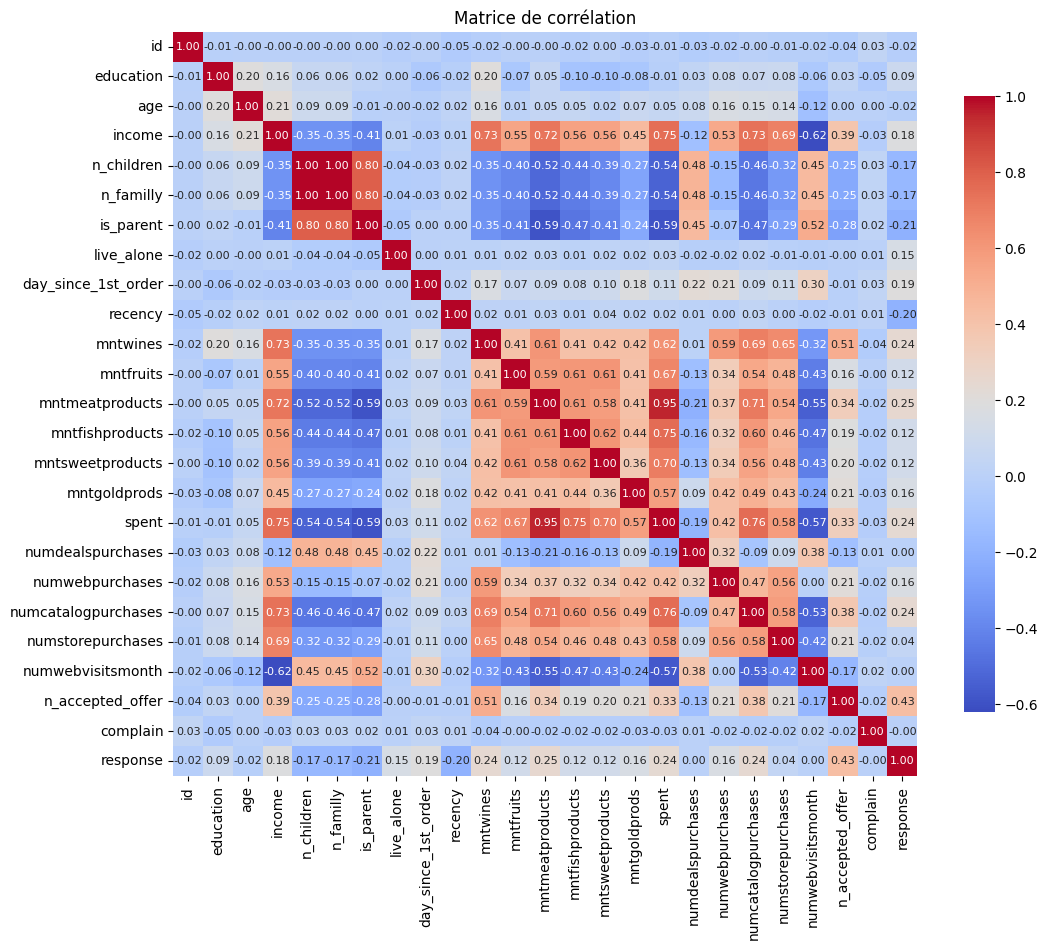

In [195]:
plt.figure(figsize=(12, 10))
correlation_matrix_imputed = df_imputed.corr()
sns.heatmap(correlation_matrix_imputed, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={'size' : 8})
plt.title('Matrice de corrélation')
plt.show()


In [196]:
correlation_matrix_imputed

,id,education,age,income,n_children,n_familly,is_parent,live_alone,day_since_1st_order,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,spent,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,n_accepted_offer,complain,response
id,1.000000,-0.009550,-0.004484,-0.002153,-0.000146,-0.000146,0.000493,-0.019342,-0.000240,-0.046524,-0.020750,-0.000532,-0.003802,-0.021893,0.004438,-0.025501,-0.011289,-0.033693,-0.024939,-0.000200,-0.014927,-0.015677,-0.035907,0.033883,-0.021968
education,-0.009550,1.000000,0.195549,0.155878,0.057994,0.057994,0.023671,0.004597,-0.059890,-0.016347,0.197830,-0.073653,0.046767,-0.095391,-0.102814,-0.077990,-0.014461,0.032634,0.081691,0.070544,0.081646,-0.064619,0.033020,-0.046990,0.085870
age,-0.004484,0.195549,1.000000,0.213885,0.094725,0.094725,-0.012502,-0.000816,-0.016048,0.019017,0.163873,0.010012,0.045505,0.053816,0.023113,0.070760,0.053417,0.082067,0.159513,0.147650,0.139846,-0.124857,0.001698,0.000282,-0.018322
income,-0.002153,0.155878,0.213885,1.000000,-0.345522,-0.345522,-0.406320,0.008548,-0.026844,0.007373,0.732492,0.545199,0.721739,0.558853,0.556354,0.447879,0.752417,-0.123388,0.530103,0.734531,0.688212,-0.620479,0.389927,-0.029391,0.177249
n_children,-0.000146,0.057994,0.094725,-0.345522,1.000000,1.000000,0.797994,-0.036965,-0.025551,0.018053,-0.353676,-0.395696,-0.516934,-0.437830,-0.390448,-0.268157,-0.537982,0.478565,-0.154786,-0.458406,-0.321125,0.446761,-0.245423,0.031066,-0.169163
n_familly,-0.000146,0.057994,0.094725,-0.345522,1.000000,1.000000,0.797994,-0.036965,-0.025551,0.018053,-0.353676,-0.395696,-0.516934,-0.437830,-0.390448,-0.268157,-0.537982,0.478565,-0.154786,-0.458406,-0.321125,0.446761,-0.245423,0.031066,-0.169163
is_parent,0.000493,0.023671,-0.012502,-0.406320,0.797994,0.797994,1.000000,-0.054666,0.001045,0.000505,-0.346410,-0.411552,-0.593973,-0.465812,-0.405763,-0.243592,-0.594828,0.447681,-0.074694,-0.473833,-0.286333,0.515310,-0.282800,0.020336,-0.205134
live_alone,-0.019342,0.004597,-0.000816,0.008548,-0.036965,-0.036965,-0.054666,1.000000,0.004071,0.007236,0.007406,0.021091,0.030696,0.011016,0.022946,0.015383,0.031564,-0.018940,-0.016011,0.018365,-0.006557,-0.013284,-0.002771,0.005572,0.146566
day_since_1st_order,-0.000240,-0.059890,-0.016048,-0.026844,-0.025551,-0.025551,0.001045,0.004071,1.000000,0.024522,0.165682,0.071712,0.086619,0.082656,0.095769,0.180590,0.113248,0.223340,0.211437,0.093627,0.110592,0.297908,-0.011143,0.033120,0.194481
recency,-0.046524,-0.016347,0.019017,0.007373,0.018053,0.018053,0.000505,0.007236,0.024522,1.000000,0.015336,0.013813,0.027178,0.012037,0.036853,0.019825,0.024417,0.007383,0.000923,0.031687,0.000799,-0.022750,-0.011064,0.013231,-0.198437


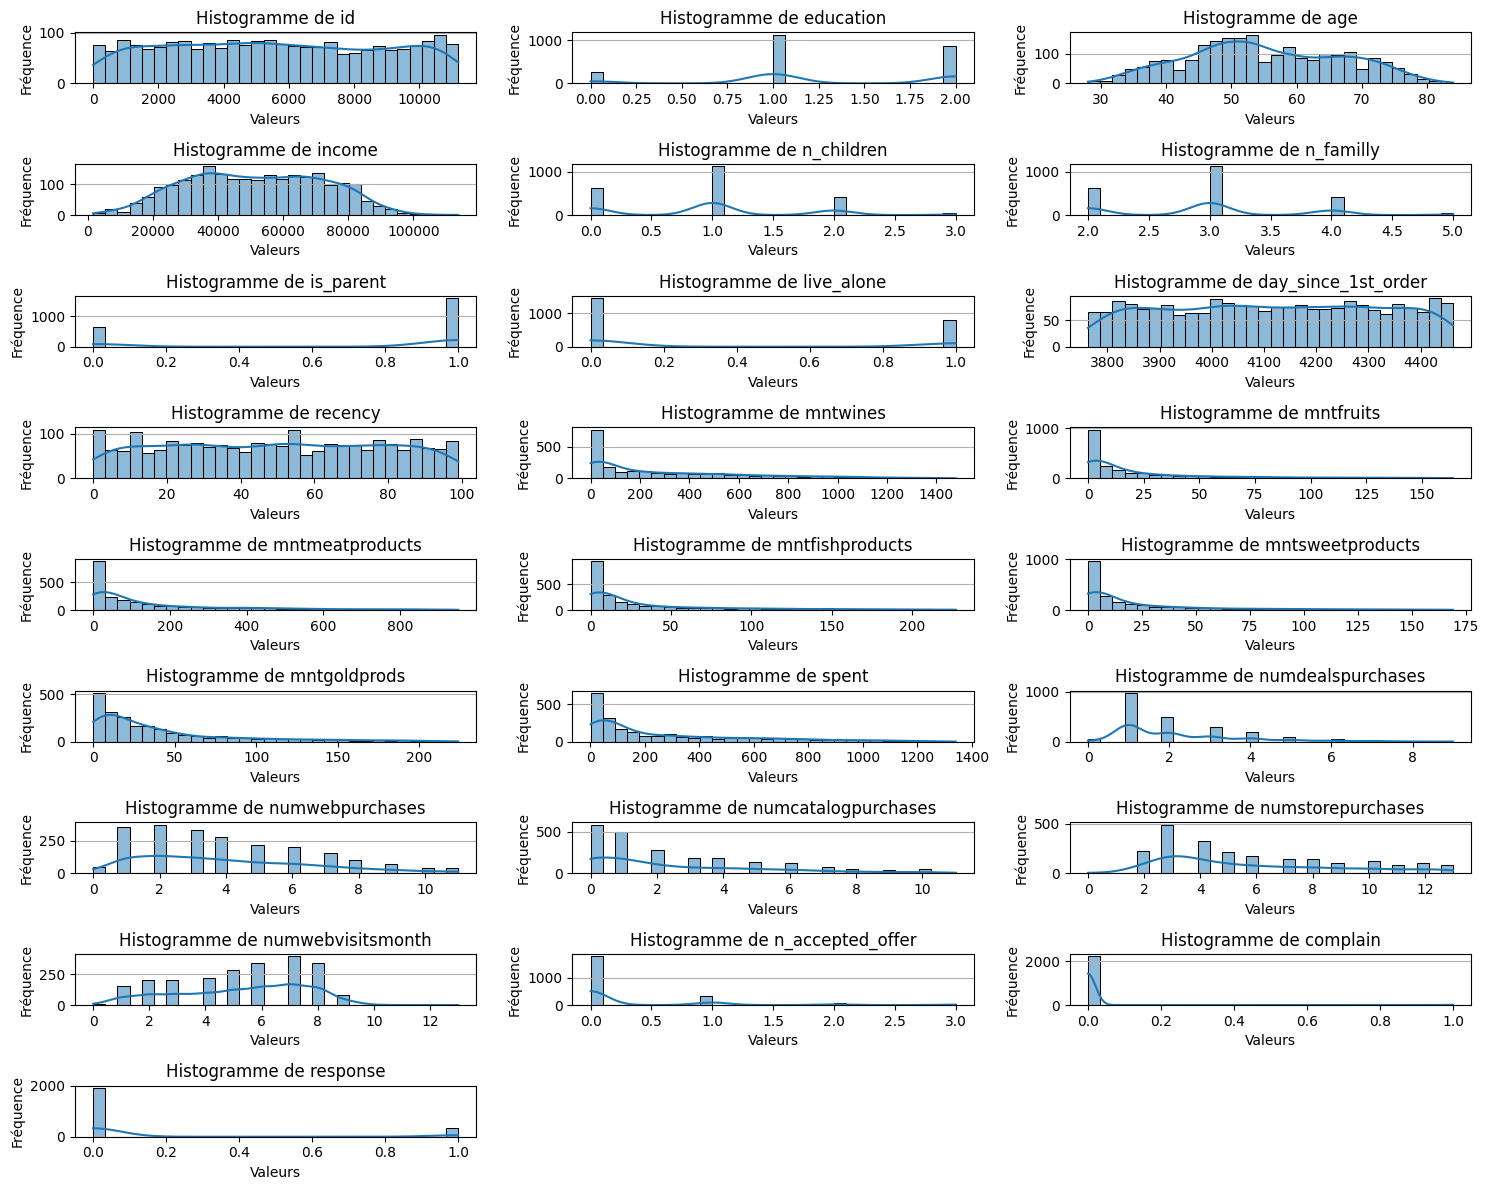

In [197]:
# Distribution des valeurs
cols = df_imputed.columns

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des histogrammes
for i, col in enumerate(cols):
    sns.histplot(df_imputed[col], bins=30, kde=True, ax=axes[i])  # Utiliser l'axe spécifique
    axes[i].set_title(f'Histogramme de {str(col)}')
    axes[i].set_xlabel('Valeurs')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()

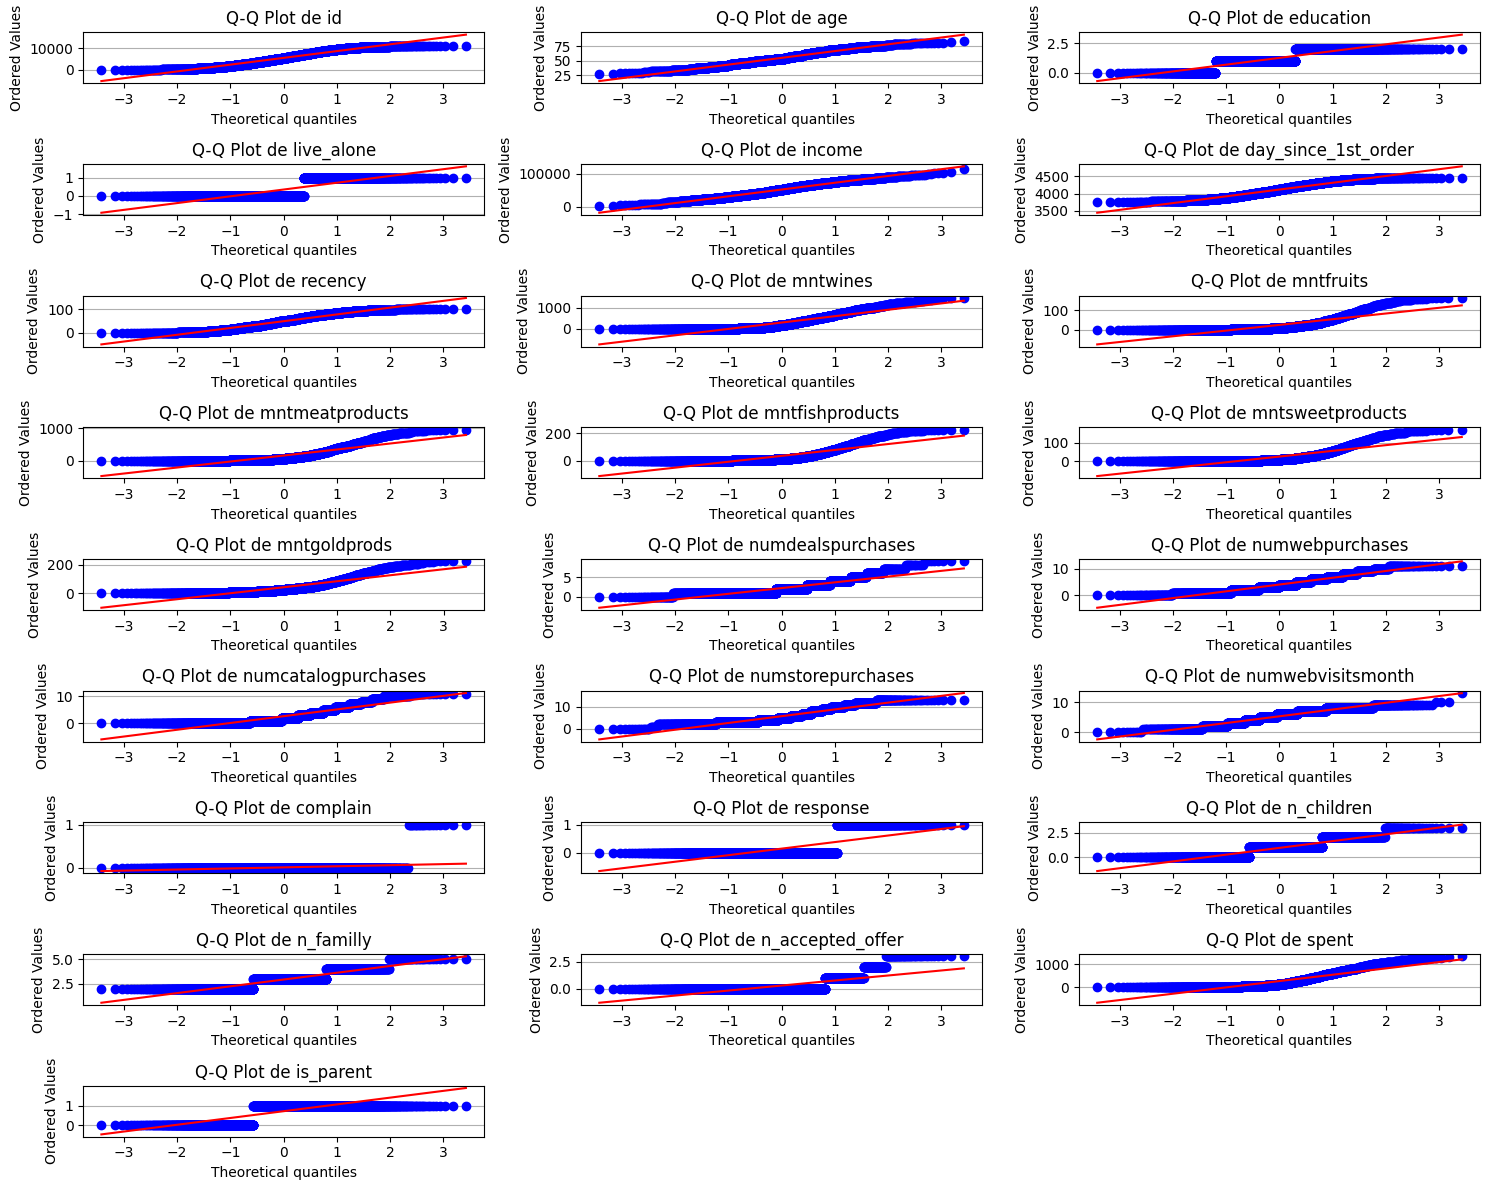

In [198]:
# Supposons que df est déjà défini et que tu as les colonnes que tu veux analyser
cols = df.columns

# Définir le nombre de lignes et de colonnes pour les subplots
n_cols = 3
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)  # Arrondi vers le haut si besoin
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))

# Aplatir les axes pour faciliter l'itération
axes = axes.flatten()

# Boucle à travers les colonnes pour créer des Q-Q plots
for i, col in enumerate(cols):
    data = df[col].dropna()  # Supprimer les NaN
    if len(data) > 1:  # Vérifier que la longueur est suffisante
        stats.probplot(data, dist="norm", plot=axes[i])  # Utiliser l'axe spécifique
        axes[i].set_title(f'Q-Q Plot de {str(col)}')
    else:
        axes[i].set_title(f'Pas assez de données pour {str(col)}')  # Titre pour les colonnes insuffisantes
    axes[i].grid(axis='y')

# Supprimer les axes inutilisés (s'ils existent)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()

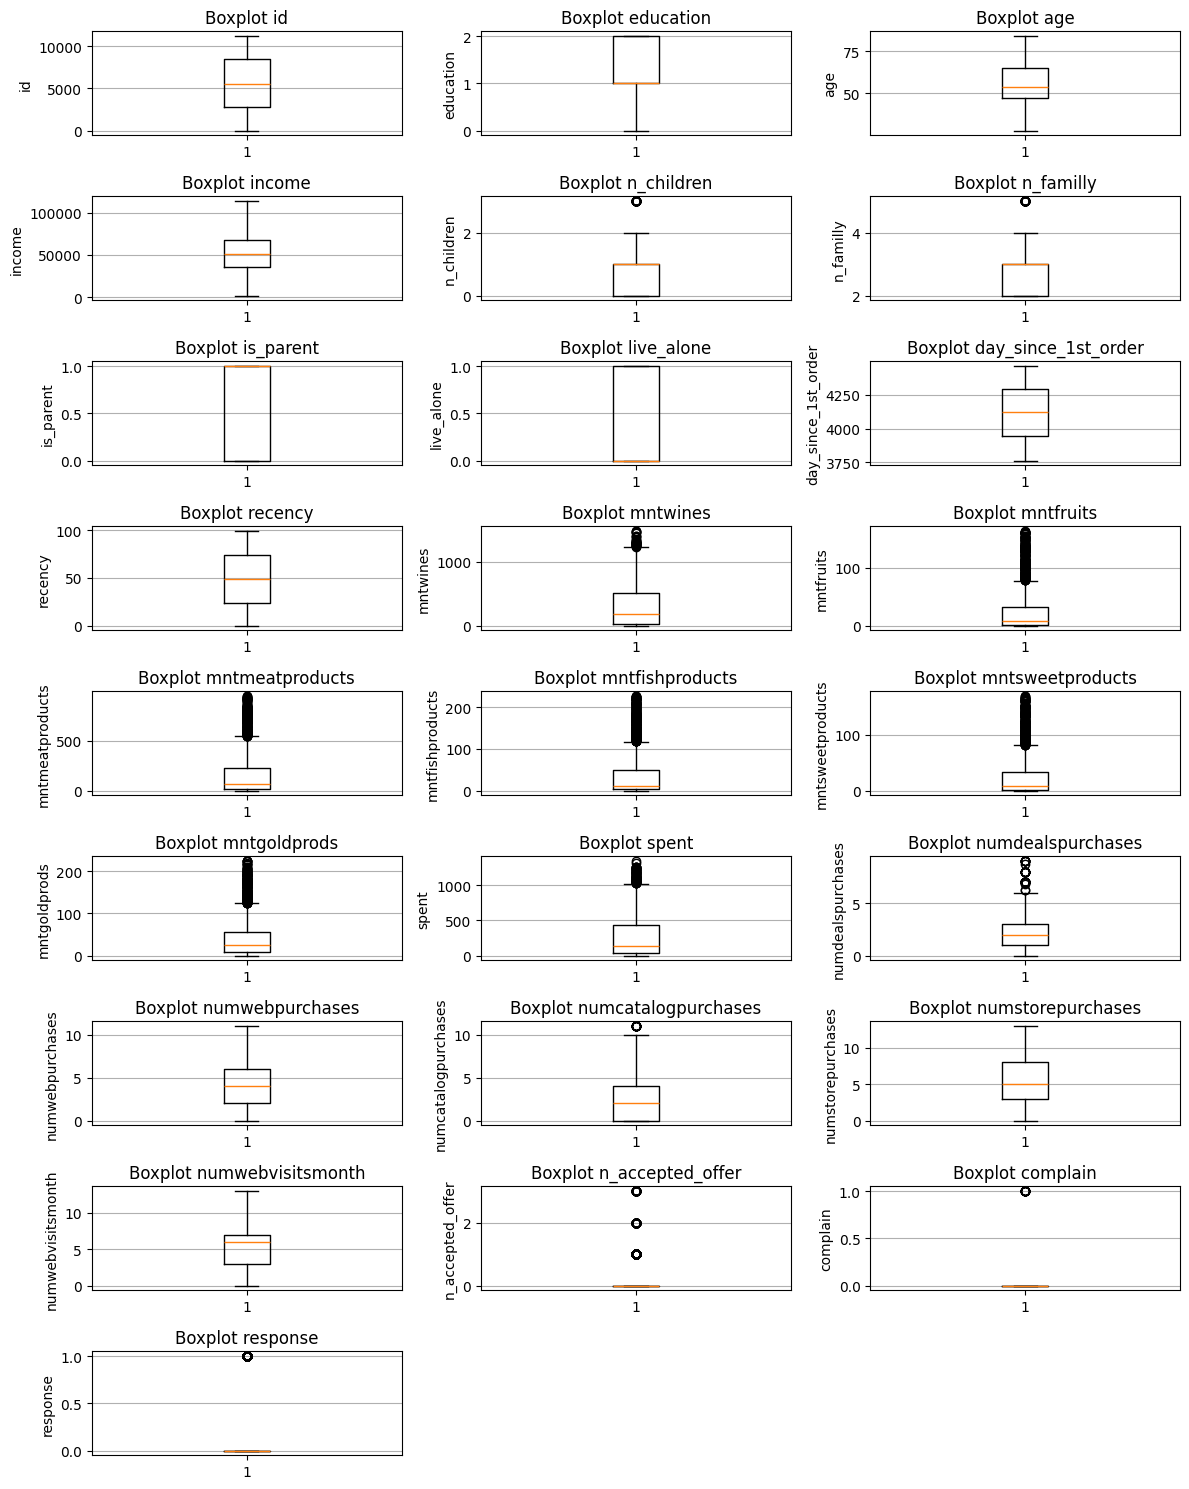

In [199]:
### Générer boxplot pour valeurs aberrantes

cols = df_imputed.columns

fig, axes = plt.subplots(nrows=len(cols)//3 + 1, ncols=3, figsize=(12, 15))  # 3 colonnes, lignes dynamiques

axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df_imputed[col])
    axes[i].set_title(f'Boxplot {str(col)}')
    axes[i].set_ylabel(str(col))
    axes[i].grid(axis='y')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Distribution des classes

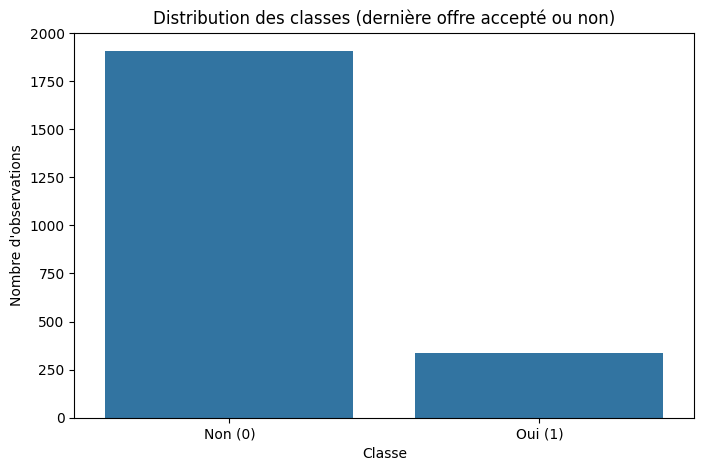

In [200]:
# Distrib classe offre accepté

plt.figure(figsize=(8, 5))
sns.countplot(x='response', data=df)
plt.title('Distribution des classes (dernière offre accepté ou non)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(ticks=[0, 1], labels=['Non (0)', 'Oui (1)'])
plt.show()

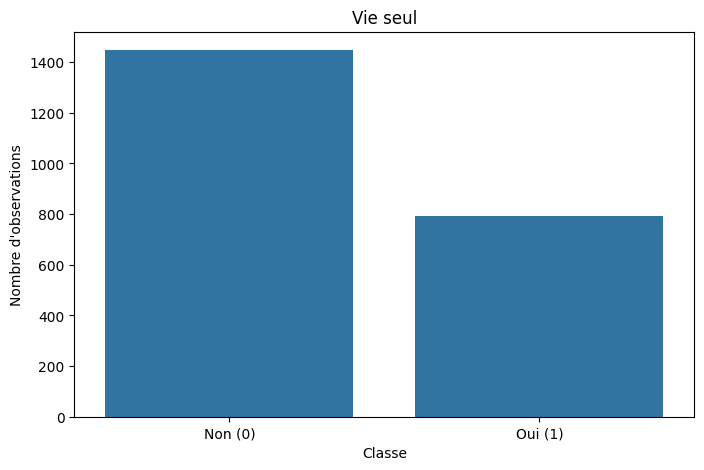

In [201]:
# Distrib classe seul ou en couple

plt.figure(figsize=(8, 5))
sns.countplot(x='live_alone', data=df)
plt.title('Vie seul')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(ticks=[0, 1], labels=['Non (0)', 'Oui (1)'])
plt.show()

Création des df segmentés

In [202]:
df_seg_demographic = df_imputed[['age', 'education', 'income', 'n_children', 'n_familly', 'is_parent']]
df_seg_behavior = df_imputed[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']]
df_seg_marketing_response = df_imputed[['n_accepted_offer', 'response']]
df_seg_lifecycle_loyalty = df_imputed[['day_since_1st_order', 'recency', 'numdealspurchases', 'complain']]
df_seg_family_profile = df_imputed[['n_children', 'n_familly', 'is_parent', 'live_alone']]
df_seg_spending_diversity = df_imputed[['spent', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']]
df_seg_platform_interaction = df_imputed[['numwebvisitsmonth', 'numwebpurchases', 'numstorepurchases']]
df_seg_high_income_high_spending = df_imputed[['income', 'spent', 'mntwines', 'mntmeatproducts', 'mntgoldprods', 'numcatalogpurchases']]
df_seg_large_families_moderate_spending = df_imputed[['n_children', 'n_familly', 'is_parent', 'mntfruits', 'mntmeatproducts', 'mntsweetproducts', 'numdealspurchases']]
df_seg_solo_client = df_imputed[['live_alone', 'mntwines', 'mntsweetproducts', 'mntgoldprods', 'numwebpurchases']]
df_seg_instore_shoppers = df_imputed[['numstorepurchases', 'mntmeatproducts', 'mntfishproducts', 'mntwines']]
df_seg_promotion_sensitive = df_imputed[['numdealspurchases', 'n_accepted_offer', 'mntsweetproducts', 'mntmeatproducts']]
df_seg_elderly_varied_shopping = df_imputed[['age', 'mntwines', 'mntfishproducts', 'numcatalogpurchases']]


Standardisation

In [203]:
# # List of variable names
# variable_names = [
#     'df_seg_demographic', 'df_seg_behavior', 'df_seg_marketing_response', 
#     'df_seg_lifecycle_loyalty', 'df_seg_family_profile', 'df_seg_spending_diversity', 
#     'df_seg_platform_interaction', 'df_seg_high_income_high_spending', 
#     'df_seg_large_families_moderate_spending', 'df_seg_solo_client', 
#     'df_seg_instore_shoppers', 'df_seg_promotion_sensitive', 
#     'df_seg_elderly_varied_shopping'
# ]

# # Loop through and scale each dataframe, then assign back to the corresponding variable
# for var_name in variable_names:
#     globals()[var_name] = scaler.fit_transform(globals()[var_name])


In [204]:
# df_scaled = scaler.fit_transform(df_imputed)

PCA segment

In [205]:
df_segs = [
    df_seg_demographic, df_seg_behavior, df_seg_marketing_response, 
    df_seg_lifecycle_loyalty, df_seg_family_profile, df_seg_spending_diversity, 
    df_seg_platform_interaction, df_seg_high_income_high_spending, 
    df_seg_large_families_moderate_spending, df_seg_solo_client, 
    df_seg_instore_shoppers, df_seg_promotion_sensitive, 
    df_seg_elderly_varied_shopping
]

In [206]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)

# for var_name in df_segs:
#     var_name = pca.fit_transform(var_name)
#     plt.figure(figsize=(6, 4))
#     plt.scatter(var_name[:, 0], var_name[:, 1], cmap='coolwarm', s=50)
#     plt.title("Repartition data après compression des dimensions")
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
#     plt.show()

In [209]:
df.isnull().sum()

id                      0
age                     3
education               0
live_alone              0
income                 32
day_since_1st_order     0
recency                 0
mntwines                4
mntfruits              32
mntmeatproducts        10
mntfishproducts        21
mntsweetproducts       32
mntgoldprods           25
numdealspurchases      24
numwebpurchases         4
numcatalogpurchases     4
numstorepurchases       0
numwebvisitsmonth       8
complain                0
response                0
n_children              0
n_familly               0
n_accepted_offer        0
spent                   7
is_parent               0
dtype: int64

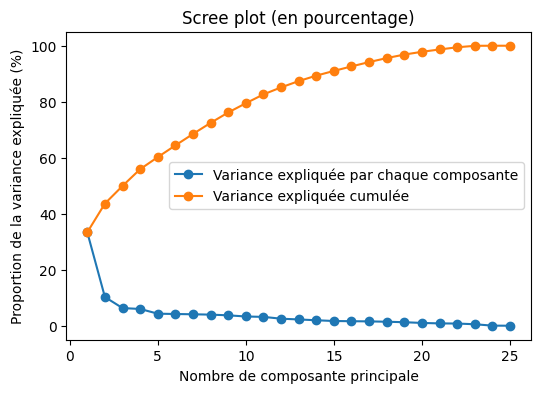

Pourcentage de variance capturée par les premières composantes : 60.21%


In [210]:
from sklearn.decomposition import PCA

# Étape 1 : Sélectionner les colonnes numériques pertinentes
 
# Étape 2 : Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[cols])
 
# Étape 3 : Appliquer PCA avec 3 composantes
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
 
explained_variance_ratio = pca.explained_variance_ratio_
 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
 
# Graphique des variances en pourcentage
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio * 100, 'o-', label='Variance expliquée cumulée')
plt.title('Scree plot (en pourcentage)')
plt.xlabel('Nombre de composante principale')
plt.ylabel('Proportion de la variance expliquée (%)')
plt.legend()
plt.show()
 
# Variance cumulée expliquée par les premières composantes
cumulative_explained_variance_ratio = np.sum(explained_variance_ratio[:5])
 
# Affichage du résultat
print(f"Pourcentage de variance capturée par les premières composantes : {cumulative_explained_variance_ratio * 100:.2f}%")

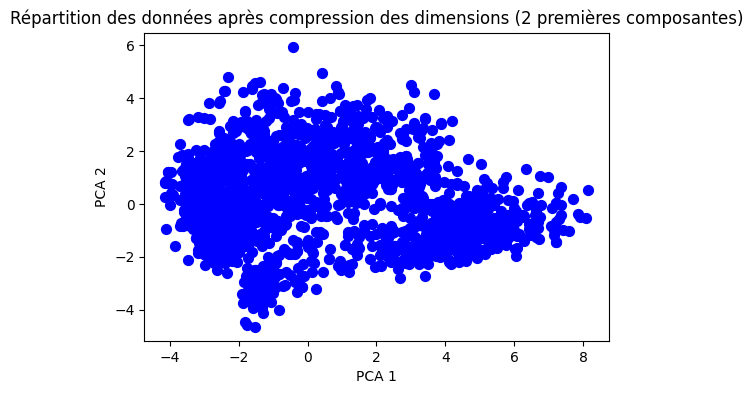

Pourcentage de variance capturée par les 5 premières composantes : 0.7945241806346328


In [219]:
# Appliquer PCA avec 5 composantes principales
pca = PCA(n_components=10)

# Transformation des données avec PCA
X_pca = pca.fit_transform(X_scaled)

# Visualisation sur les deux premières composantes
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', s=50)  # Retiré cmap ici
plt.title("Répartition des données après compression des dimensions (2 premières composantes)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Pourcentage de variance capturée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.sum(explained_variance_ratio[:10])

# Affichage du résultat
print(f"Pourcentage de variance capturée par les 5 premières composantes : {cumulative_explained_variance_ratio}")

In [161]:
print(pca.components_.shape)  # Affiche la forme pour vérifier
print(len(cols))  # Vérifie si 'cols' a bien la taille souhaitée

(2, 2)
25


In [220]:
# Assure-toi que n_components dans PCA est bien 22
components = pca.components_

# Assure-toi que df_base.index a bien 2240 lignes
components = pd.DataFrame(components.T, index=cols, columns=[f'PC{i}' for i in range(1, components.shape[0] + 1)])

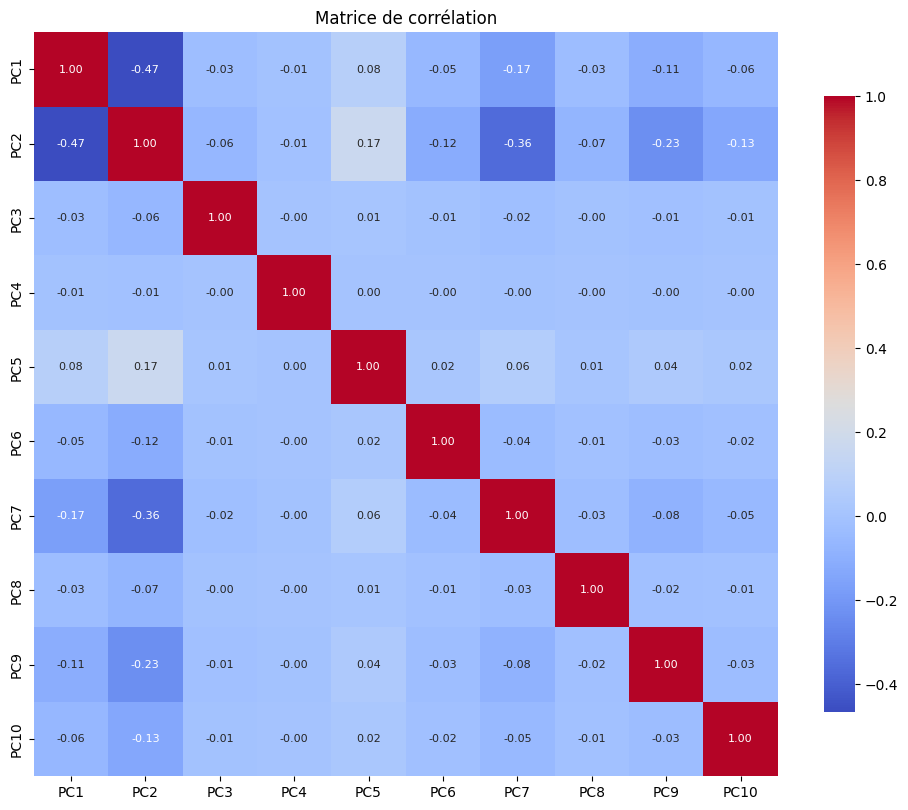

In [222]:
pca_matrix = components.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(pca_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={'size' : 8})
plt.title('Matrice de corrélation')
plt.show()

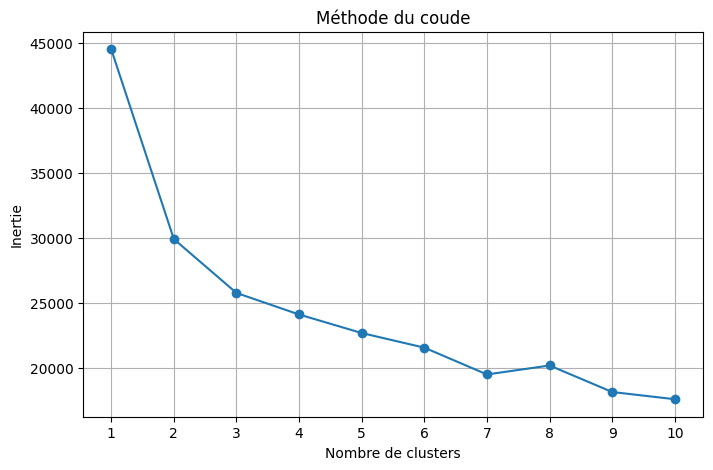

In [226]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Étape 1 : Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
K = range(1, 11)  # Tester de 1 à 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.xticks(K)
plt.grid(True)
plt.show()



Clustering

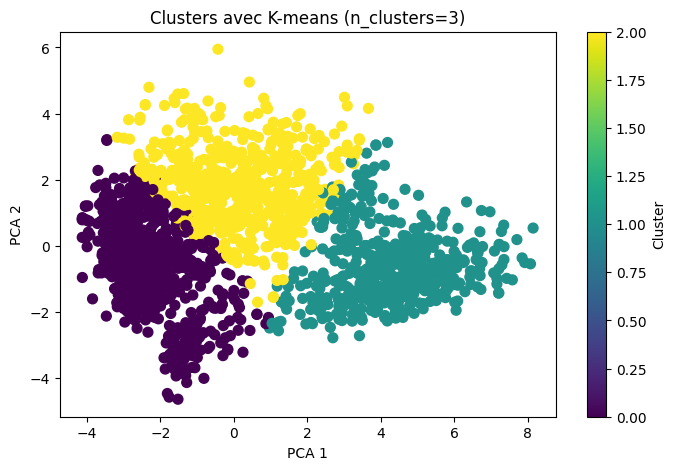

In [230]:
optimal_clusters = 3  # Choisis le nombre optimal basé sur le graphique ci-dessus
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, init='k-means++')
clusters = kmeans.fit_predict(X_pca)

# Étape 3 : Visualisation des clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title(f'Clusters avec K-means (n_clusters={optimal_clusters})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()